In [109]:
#Future imports.
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

In [110]:
#Other imports.
import pandas as pd
import numpy as np

import stop_words
from nltk.tokenize import TreebankWordTokenizer, RegexpTokenizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer

import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

import time      

import pickle

In [111]:
#Define the timeit decorator.                                          
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed

In [112]:
#Define pickling functions.
def pickle_dump(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
    
def pickle_load(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [113]:
#Gets data and stores it as a dataframe.
def fetch():
    train_haptik = pd.read_csv('./data/domain_classification/train_data.csv', encoding='UTF-8')
    test_haptik = pd.read_csv('./data/domain_classification/test_data.csv', encoding='UTF-8')
    return train_haptik, test_haptik

In [114]:
#Separates feature and target variables.
def feature_target_separator(df):
    feature = df.iloc[:,0]
    target = df.iloc[:,1:]
    return feature, target

In [115]:
#Reverse OHE
@timeit
def reverse_ohe(df):
    for column in df.columns:
        df[column] = df[column].astype(str).map({'F':0, 'T':1})
    return df


In [116]:
#Will replace rows with multiple labels with only the first label.
def replace_multi_label(df):
    df = df.idxmax(1)
    return df

In [117]:
#Perform pre-processing(Tokenize, remove stop words and stem)
@timeit
def preprocess(input_ls, stem=False):
    tokenizer_obj= TreebankWordTokenizer()
    ps = PorterStemmer()
    input_ls = [x.lower() for x in input_ls]
    tokens = [tokenizer_obj.tokenize(x) for x in input_ls]
    stopwords = stop_words.get_stop_words('english')
    stopwords.extend(['{','}', 'task_name', 'api_name', 'product_id',
                      "n't", 'thanks','hey','please','hello','user_id',
                      'plz','a9c0', '676951', 'hi', '727893', '55616','want','need','ll','know','go',
                      'tell','check','good','give','go','still','will','help','pl','now','looking','hai','find',
                      'let','ye','sorry','okay','ok'])
    #print(stopwords)
    input_ls = [list(set(x).difference(set(stopwords))) for x in tokens]
    if stem:
        input_ls = [map(ps.stem,x) for x in input_ls]
    return input_ls
    

In [118]:
#Makes a wordcloud.
@timeit
def word_cloud(list_of_tokens):
    temp_list = []
    _ = [temp_list.extend(x) for x in list_of_tokens]
    word_cloud_object = WordCloud(max_font_size=30)
    word_cloud_object.generate(' '.join(temp_list))
    plt.figure(figsize=(10,10))
    plt.imshow(word_cloud_object)
    dk = word_cloud_object.words_
    return sorted(dk.items(), key=lambda x:x[1])
    #print(temp_list)

In [119]:
train, test = fetch()

train_feature_haptik, train_target_haptik = feature_target_separator(train)
train_target_haptik = reverse_ohe(train_target_haptik)
#train_target_haptik = replace_multi_label(train_target_haptik)

test_feature_haptik, test_target_haptik = feature_target_separator(test)
test_target_haptik = reverse_ohe(test_target_haptik)
#test_target_haptik = replace_multi_label(test_target_haptik)

/home/daksha/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


'reverse_ohe'  7480.60 ms
'reverse_ohe'  1311.30 ms


In [120]:
list_of_train_tokens = preprocess(train_feature_haptik, stem=False)
list_of_test_tokens = preprocess(test_feature_haptik, stem=False)

'preprocess'  7448.42 ms
'preprocess'  1821.19 ms


'word_cloud'  3687.72 ms


,0,1
199,train,1.000000
198,ticket,0.994643
197,offset cancel,0.893750
196,exotel reminder_list,0.853571
195,offer,0.682143


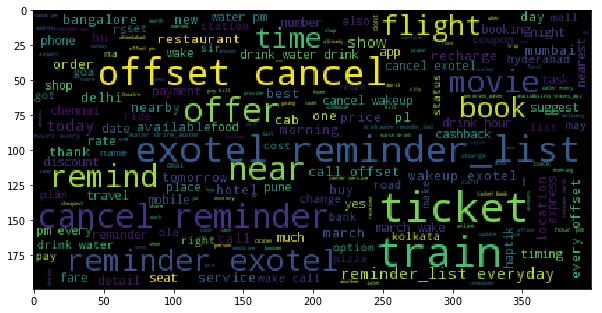

In [121]:
tr_ls = word_cloud(list_of_train_tokens)
pd.DataFrame(tr_ls).sort_values(by=1, ascending=False).head()

'word_cloud'  17930.90 ms


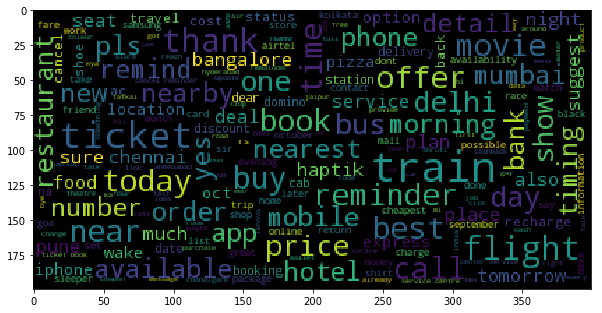

In [169]:
tmp = word_cloud(list_of_test_tokens)

In [123]:
@timeit
def createDF(message_list,category_df):
    m_series = pd.Series(message_list)
    m_series = m_series.apply(lambda x:' '.join(x))
    fin_df = pd.concat([m_series,category_df],axis=1)
    fin_df = fin_df.rename(columns={0:'message',1:'category'})
    return fin_df
    


In [124]:
train_df = createDF(list_of_train_tokens,train_target_haptik)
test_df = createDF(list_of_test_tokens,test_target_haptik)
len(train_df)

'createDF'  99.27 ms
'createDF'  14.17 ms


40659

support       1847
other         2989
recharge      3087
food          3979
movies        4004
nearby        4591
casual        6055
reminders     7331
travel       13504
dtype: int64

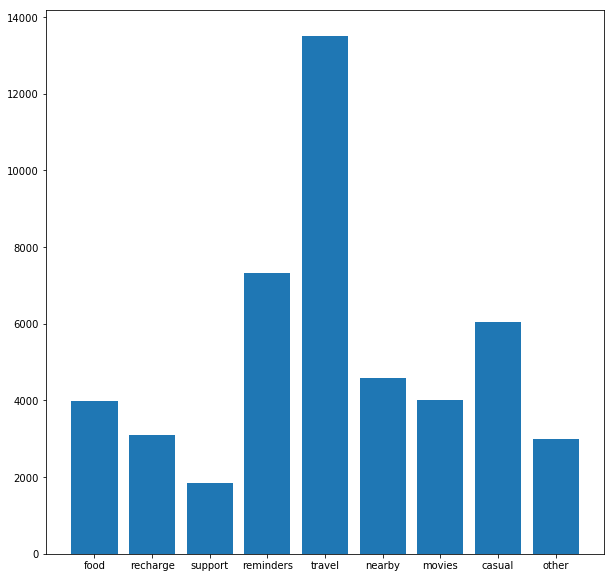

In [125]:
plt.figure(figsize=(10,10))
hi = train_df[train_df.columns[1:]].sum()
plt.bar(range(len(hi.index)), hi.values)
plt.xticks(range(len(hi.index)),hi.index)
hi.sort_values()

support       371
recharge      450
movies        637
nearby        807
food          810
reminders     893
other        1668
travel       2138
casual       3282
dtype: int64

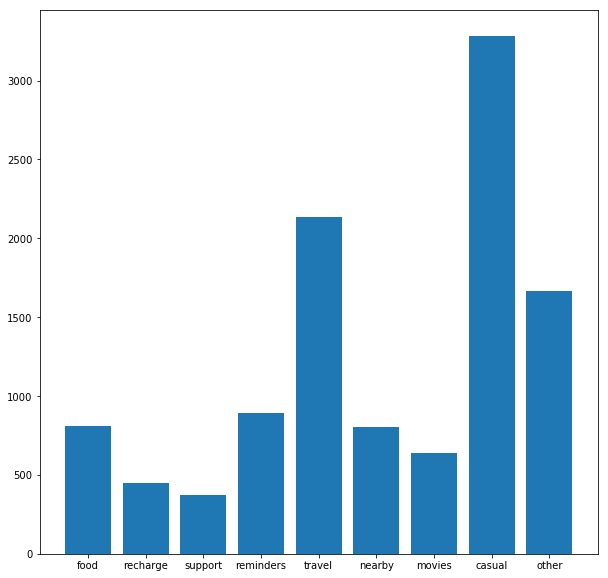

In [158]:
plt.figure(figsize=(10,10))
hi = test_df[test_df.columns[1:]].sum()
plt.bar(range(len(hi.index)), hi.values)
plt.xticks(range(len(hi.index)),hi.index)
hi.sort_values()

# MultinomialNB approach.(Uses only single label.)

In [126]:
# @timeit
# def train_clf(df):
#     t = TreebankWordTokenizer()
#     sw = stop_words.get_stop_words('english')
#     df = df.sample(frac=1, replace=False)
#     X_train = df['message']
#     Y_train = df['category']
#     #lbe = LabelEncoder()
#     #Y_train = lbe.fit_transform(Y_train)
#     #vect = CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.2)
#     vect = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.5, norm='l1')
#     X_train_dtm = vect.fit_transform(X_train)
#     clf = MultinomialNB(alpha=0.25, fit_prior=False)
#     clf.fit(X_train_dtm,Y_train)
#     #print(clf)
#     return clf,vect

# train_clf(train_df)

In [127]:
# @timeit
# def classify((clf_obj,vect),df):
#     df = df.sample(frac=1, replace=False)
#     X_test = df['message']
#     Y_test = df['category']
#     #lbe = LabelEncoder()
#     #Y_test = lbe.fit_transform(Y_test)
#     X_test_dtm = vect.transform(X_test)
#     Y_pred = clf_obj.predict(X_test_dtm)
#     print('Accuracy is: {}'.format(accuracy_score(Y_test,Y_pred)*100))
#     print(classification_report(Y_test,Y_pred))
#     print()
#     print(confusion_matrix(Y_test,Y_pred))
#     print()
#     print(cross_val_score(clf_obj,X_test_dtm,Y_test,cv=10))
#     print(cross_val_score(clf_obj,X_test_dtm,Y_test,cv=10).mean())
#     return Y_pred

In [128]:
#classify(train_clf(train_df),test_df)

## Decision Tree

In [129]:
dt_clf, dt_vect = train_ovr(train_df['message'], train_df[train_df.columns[1:]], vect=CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.5), clf=DecisionTreeClassifier(min_samples_split=50, criterion='gini'))

'train_ovr'  15382.63 ms


In [130]:
pred_rf(test_df['message'], test_df[test_df.columns[1:]], dt_vect, dt_clf)

Subset accuracy is 0.7368
Label accuracy is 0.941755555556
             precision    recall  f1-score   support

          0       0.78      0.58      0.66       810
          1       0.68      0.70      0.69       450
          2       0.59      0.27      0.37       371
          3       0.83      0.83      0.83       893
          4       0.80      0.82      0.81      2138
          5       0.64      0.62      0.63       807
          6       0.74      0.59      0.66       637
          7       0.81      0.85      0.83      3282
          8       0.85      0.55      0.67      1668

avg / total       0.79      0.72      0.74     11056

'pred_rf'  349.27 ms


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

# Random Forest Classifier. (Supports multiple labels)

In [131]:
#train random-forest-classifier
@timeit
def train_rf(X, Y, vect=TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.5, norm='l1'), clf=RandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=50)):
    X_train = vect.fit_transform(X)
    rf_clf = clf
    rf_clf.fit(X_train, Y)
    return rf_clf, vect

In [132]:
#predict method. make sure that you pass the exact same vectorizer as you used in train.
@timeit
def pred_rf(X, Y, vect, clf):
    X_test = vect.transform(X)
    Y_pred = clf.predict(X_test)
    print('Subset accuracy is {}'.format(accuracy_score(Y, Y_pred)))
    msk = Y_pred == Y
    label_acc = msk.sum().sum()/msk.size
    print('Label accuracy is {}'.format(label_acc))
    #cv = cross_val_score(clf, X_test, Y,cv=10)
    #print(cv)
    #print(cv.mean())
    print(classification_report(Y, Y_pred))
    return Y_pred
    

In [133]:
train_df.columns

Index([u'message', u'food', u'recharge', u'support', u'reminders', u'travel',
       u'nearby', u'movies', u'casual', u'other'],
      dtype='object')

In [134]:
train_df = train_df.sample(frac=1)
rf_clf, vect_obj = train_rf(train_df['message'], train_df[train_df.columns[1:]],  vect=CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.5), )

'train_rf'  148148.02 ms


In [135]:
test_df = test_df.sample(frac=1)
pred_op = pred_rf(test_df['message'], test_df[test_df.columns[1:]], vect_obj, rf_clf)

Subset accuracy is 0.7472
Label accuracy is 0.947966666667
             precision    recall  f1-score   support

          0       0.83      0.61      0.70       810
          1       0.76      0.68      0.72       450
          2       0.71      0.26      0.38       371
          3       0.86      0.84      0.85       893
          4       0.82      0.85      0.84      2138
          5       0.74      0.62      0.68       807
          6       0.81      0.61      0.70       637
          7       0.83      0.86      0.84      3282
          8       0.92      0.53      0.68      1668

avg / total       0.83      0.73      0.77     11056

'pred_rf'  9039.16 ms


# How the classifier performed on rows having multiple labels.

In [136]:
ser = test_df[test_df.columns[1:]].sum(axis=1)
msk = ser > 1
ser[msk].index

Int64Index([6846, 7041, 9903, 9895, 5632, 9856, 8046, 9028, 8006, 5704,
            ...
            9205, 9852, 8381, 5180, 9014, 9256, 9108, 5330, 5276, 6246],
           dtype='int64', length=508)

In [137]:
multi_df = test_df[test_df.index.isin(ser[msk].index)]
multi_df.drop('message', axis=1, inplace=True)

/home/daksha/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [138]:
op_df = pd.DataFrame(pred_op, columns=test_df.columns[1:], index=test_df.index)
op_multi = op_df[op_df.index.isin(ser[msk].index)]

In [139]:
print(len(op_multi), len(multi_df))

508 508


In [140]:
print(accuracy_score(multi_df, op_multi))

0.0944881889764


# Experimenting with OneVsRestClassifier

## RandomForest + OneVsRestClassifier

In [141]:
@timeit
def train_ovr(X, Y, vect=TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.5), clf=OneVsRestClassifier(RandomForestClassifier(n_estimators=50))):
    X_train = vect.fit_transform(X)
    rf_clf = clf
    rf_clf.fit(X_train, Y)
    return rf_clf, vect

In [142]:
ovr_rf_clf, ovr_rf_vect = train_ovr(train_df['message'], train_df[train_df.columns[1:]])

'train_ovr'  493977.30 ms


In [143]:
y_rf_op = pred_rf(test_df['message'], test_df[test_df.columns[1:]], ovr_rf_vect, ovr_rf_clf)

Subset accuracy is 0.7207
Label accuracy is 0.947211111111
             precision    recall  f1-score   support

          0       0.82      0.62      0.71       810
          1       0.78      0.66      0.71       450
          2       0.68      0.33      0.45       371
          3       0.86      0.85      0.85       893
          4       0.81      0.86      0.84      2138
          5       0.65      0.65      0.65       807
          6       0.83      0.65      0.73       637
          7       0.83      0.83      0.83      3282
          8       0.89      0.59      0.71      1668

avg / total       0.82      0.74      0.77     11056

'pred_rf'  23441.86 ms


## SVM + OneVsRestClassifier

In [144]:
#svm_clf, svm_vect = train_ovr(train_df['message'], train_df[train_df.columns[1:]], vect=TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.5), clf=OneVsRestClassifier(SVC(C=5, kernel='linear')))

In [145]:
pickle_dump(svm_clf, 'LinearSVM')
pickle_dump(svm_vect, "LinearSVMVect")

In [146]:
svm_clf = pickle_load('LinearSVM')
svm_vect = pickle_load('LinearSVMVect')

In [147]:
y_op = pred_rf(test_df['message'], test_df[test_df.columns[1:]], svm_vect, svm_clf)

Subset accuracy is 0.663
Label accuracy is 0.930344444444
             precision    recall  f1-score   support

          0       0.69      0.57      0.62       810
          1       0.65      0.67      0.66       450
          2       0.31      0.22      0.26       371
          3       0.81      0.79      0.80       893
          4       0.78      0.82      0.80      2138
          5       0.58      0.58      0.58       807
          6       0.56      0.47      0.51       637
          7       0.75      0.83      0.79      3282
          8       0.84      0.51      0.63      1668

avg / total       0.73      0.69      0.70     11056

'pred_rf'  30838.74 ms


## MultinomialNB + OneVsRestClassifier

In [148]:
mnb_clf, mnb_vect = train_ovr(train_df['message'], train_df[train_df.columns[1:]], vect=CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.5), clf=OneVsRestClassifier(MultinomialNB(alpha=0.45)))

'train_ovr'  2888.16 ms


In [149]:
pred_rf(test_df['message'], test_df[test_df.columns[1:]], mnb_vect, mnb_clf)

Subset accuracy is 0.6175
Label accuracy is 0.936566666667
             precision    recall  f1-score   support

          0       0.76      0.64      0.69       810
          1       0.64      0.68      0.66       450
          2       0.61      0.43      0.51       371
          3       0.90      0.79      0.84       893
          4       0.78      0.88      0.83      2138
          5       0.55      0.66      0.60       807
          6       0.77      0.62      0.69       637
          7       0.87      0.54      0.66      3282
          8       0.88      0.66      0.76      1668

avg / total       0.80      0.67      0.72     11056

'pred_rf'  344.34 ms


array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

## LogisticRegression + OneVsRestClassifier

In [150]:
lr_clf, lr_vect = train_ovr(train_df['message'], train_df[train_df.columns[1:]], vect=CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.5), clf=OneVsRestClassifier(LogisticRegression(solver='newton-cg', multi_class='multinomial')))

'train_ovr'  21576.05 ms


In [151]:
pred_rf(test_df['message'], test_df[test_df.columns[1:]], lr_vect, lr_clf)

Subset accuracy is 0.6585
Label accuracy is 0.945411111111
             precision    recall  f1-score   support

          0       0.89      0.58      0.70       810
          1       0.82      0.61      0.70       450
          2       0.82      0.32      0.46       371
          3       0.91      0.81      0.86       893
          4       0.86      0.85      0.85      2138
          5       0.73      0.60      0.66       807
          6       0.91      0.56      0.69       637
          7       0.90      0.59      0.71      3282
          8       0.94      0.58      0.72      1668

avg / total       0.88      0.64      0.74     11056

'pred_rf'  296.30 ms


array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

## Decision Tree + OneVsRestClassifier

In [152]:
dt_ovr_clf, dt_ovr_vect = train_ovr(train_df['message'], train_df[train_df.columns[1:]], vect=CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.5), clf=OneVsRestClassifier(DecisionTreeClassifier(min_samples_split=50, criterion='entropy')))

'train_ovr'  80162.15 ms


In [153]:
pred_rf(test_df['message'], test_df[test_df.columns[1:]], dt_ovr_vect, dt_ovr_clf)

Subset accuracy is 0.7
Label accuracy is 0.942944444444
             precision    recall  f1-score   support

          0       0.80      0.62      0.70       810
          1       0.68      0.65      0.67       450
          2       0.68      0.33      0.45       371
          3       0.86      0.80      0.83       893
          4       0.79      0.84      0.81      2138
          5       0.64      0.60      0.62       807
          6       0.75      0.61      0.67       637
          7       0.80      0.87      0.83      3282
          8       0.87      0.58      0.70      1668

avg / total       0.79      0.73      0.75     11056

'pred_rf'  679.18 ms


array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [170]:
pd.DataFrame(rez, columns=['Model', 'Subset Accuracy', 'Label Accuracy', 'Predict time(ms)'], index=range(1,8))

,Model,Subset Accuracy,Label Accuracy,Predict time(ms)
1,Decision Tree,0.736,0.941,349.27
2,Random Forest,0.747,0.947,9039.16
3,OVR+Random Forest,0.720,0.947,23441.80
4,OVR+SVM,0.660,0.930,30838.74
5,OVR+MultinomialNB,0.610,0.936,344.27
6,OVR+LogisticRegression,0.650,0.945,296.30
7,OVR+Decision Tree,0.700,0.942,679.18
